In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

In [2]:
# Vérification du dossier de résultats
os.makedirs('results', exist_ok=True)

In [3]:
# Charger les fichiers
X_file = "data/X_matrix.csv"
Y_file = "data/Y_matrix.csv"

print("Chargement des données...")
X = pd.read_csv(X_file)
Y = pd.read_csv(Y_file)

Chargement des données...


In [4]:
# S'assurer que Yeast_ID est une chaîne
X['Yeast_ID'] = X['Yeast_ID'].astype(str)
Y['Yeast_ID'] = Y['Yeast_ID'].astype(str)

# S'assurer que les Yeast_ID sont alignés
print("Vérification de l'ordre des Yeast_ID...")
if not all(X["Yeast_ID"] == Y["Yeast_ID"]):
    raise ValueError("L'ordre des Yeast_ID ne correspond pas entre les deux fichiers.")


Vérification de l'ordre des Yeast_ID...


In [5]:
# Préparer les données
print("Préparation des données...")
X_data = X.drop(columns=["Yeast_ID"]).fillna(0)  # Remplacer les valeurs manquantes par 0 dans X
Y_data = Y.drop(columns=["Yeast_ID"]).fillna(Y.drop(columns=["Yeast_ID"]).mean())  # Remplacer les valeurs manquantes par la moyenne dans Y

Préparation des données...


In [6]:
# Division des données en ensembles d'entraînement et de test
print("Division des données en ensembles d'entraînement et de test...")
sss = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_index, test_index = next(sss.split(X_data, Y_data))

X_train, X_test = X_data.iloc[train_index, :], X_data.iloc[test_index, :]
y_train, y_test = Y_data.iloc[train_index, :], Y_data.iloc[test_index, :]

# Mise à l'échelle des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

Division des données en ensembles d'entraînement et de test...


In [7]:
print("Définition des paramètres pour la recherche aléatoire...")
GBM_distributions = dict(
    max_features=["auto", "log2", "sqrt"],
    learning_rate=uniform(1e-3, 1),
    subsample=uniform(0, 1),
    min_samples_split=randint(2, 100),
    min_samples_leaf=randint(2, 100),
    n_estimators=randint(10, 200),
    criterion=['friedman_mse', 'squared_error'],
    max_depth=randint(2, 10)
)

Définition des paramètres pour la recherche aléatoire...


In [8]:
# Entraînement multitâche avec RandomizedSearchCV
print("Lancement de l'entraînement multitâche avec Gradient Boosting...")
n_iterations = 100
cross_val = 3
num_jobs = -1

multireg = MultiOutputRegressor(RandomizedSearchCV(
    GradientBoostingRegressor(loss="squared_error", n_iter_no_change=5),
    GBM_distributions,
    n_iter=n_iterations,
    verbose=10,
    cv=cross_val,
    n_jobs=num_jobs
)).fit(X_train_scaled, y_train_scaled)

Lancement de l'entraînement multitâche avec Gradient Boosting...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3; 1/100] START criterion=friedman_mse, learning_rate=0.8694762127398737, max_depth=6, max_features=auto, min_samples_leaf=65, min_samples_split=82, n_estimators=34, subsample=0.3726431478262664
[CV 2/3; 1/100] START criterion=friedman_mse, learning_rate=0.8694762127398737, max_depth=6, max_features=auto, min_samples_leaf=65, min_samples_split=82, n_estimators=34, subsample=0.3726431478262664
[CV 3/3; 1/100] START criterion=friedman_mse, learning_rate=0.8694762127398737, max_depth=6, max_features=auto, min_samples_leaf=65, min_samples_split=82, n_estimators=34, subsample=0.3726431478262664
[CV 3/3; 2/100] START criterion=friedman_mse, learning_rate=0.07478465479985696, max_depth=9, max_features=log2, min_samples_leaf=61, min_samples_split=84, n_estimators=173, subsample=0.10612973052645158
[CV 2/3; 2/100] START criterion=friedman_mse, learning_rate=0.074

In [9]:
# Prédictions
print("Prédictions sur les données de test...")
multi_reg_pred = multireg.predict(X_test_scaled)

Prédictions sur les données de test...


In [10]:
# Sauvegarde des résultats
y_test_pred_df = pd.DataFrame(multi_reg_pred, index=y_test.index, columns=Y_data.columns)
y_test_pred_df.to_csv('results/y_test_predicted_multitarget_GBM.csv')

In [11]:
# Importance des caractéristiques
print("Calcul des importances des caractéristiques...")
feature_importances = []
for estimator in multireg.estimators_:
    best_estimator = estimator.best_estimator_
    importances = best_estimator.feature_importances_
    feature_importances.append(importances)

# Moyenne des importances
average_feature_importances = pd.DataFrame(feature_importances).mean(axis=0)
feature_importances_df = pd.DataFrame({
    "Feature": X_data.columns,
    "Importance": average_feature_importances
}).sort_values(by="Importance", ascending=False)
feature_importances_df.to_csv('results/feature_importances_multitarget_GBM.csv')


# Affichage des résultats
print("Enregistrement terminé. Les résultats sont sauvegardés dans le dossier 'results'.")

Calcul des importances des caractéristiques...
Enregistrement terminé. Les résultats sont sauvegardés dans le dossier 'results'.


In [12]:
# Calcul des métriques
print("Calcul des métriques...")
mse = mean_squared_error(y_test_scaled, multi_reg_pred)
r2 = r2_score(y_test_scaled, multi_reg_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.6f}")

Calcul des métriques...
Mean Squared Error: 1.637230
R² Score: 0.062717


Calcul de l'importance des caractéristiques...

Mutations ayant le plus d'impact sur le YPD doubling time :
                 Feature  Importance
8629    YBL047C_893_D->E    0.044870
209742  YLL049W_148_L->V    0.039871
346696           YNL170W    0.028020
344427           YHR043C    0.020636
185942  YJR151C_849_I->V    0.017846
346850           YNL336W    0.016635
347480           YOR392W    0.015586
346924           YNR072W    0.014553
328742  YPL222W_406_L->M    0.013385
347478           YOR388C    0.013237


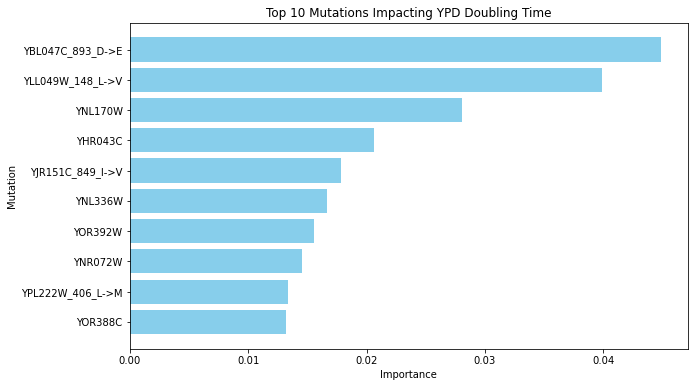

In [13]:
# Importance des caractéristiques
print("Calcul de l'importance des caractéristiques...")
top_mutations = feature_importances_df.head(10)
print("\nMutations ayant le plus d'impact sur le YPD doubling time :")
print(top_mutations)

plt.figure(figsize=(10, 6))
plt.barh(top_mutations["Feature"], top_mutations["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Mutation")
plt.title("Top 10 Mutations Impacting YPD Doubling Time")
plt.gca().invert_yaxis()
plt.show()

In [14]:
print("Les résultats sont sauvegardés dans le dossier 'results/'.")

Les résultats sont sauvegardés dans le dossier 'results/'.
